In [1]:
%config Completer.use_jedi = False

import pickle

import numpy as np
import pandas as pd

pd.set_option('mode.chained_assignment', None)

import util.explore as explore_util
import util.project as project_util

from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

import matplotlib.pyplot as plt

In [2]:
from sklearn.svm import SVC
from xgboost import XGBClassifier

## Load in all projects from project panel, and merge with MDG panel data

In [3]:
ipf_feature_cols = [
    'origcommamt',
    'lnorigcommamt',
    'cpia_approval',
    'region',
    'fundingsource', 
    'fcsatappfy',
    'uppermiddle_income_appfy',
    'origprojlength',
    'prepttl_exp',
    'lngdp_ppp',
    'iegrate' # not strictly "at approval" but important to understand relative importance, so including
]

In [4]:
during_project_features = [
    'cpia_change', 
    'gdpgrowthav', 
    'iegrate', 
    'iegsat', 
    'actprojlength',
    'changeprepttlisr12',
    'oneh_ttl_turnover',
    'twoh_ttl_turnover',
]

In [10]:
country_panel, approv_df, review_df = project_util.load_projects_with_embeddings(
    ipf_feature_cols=ipf_feature_cols,
    during_project_features=during_project_features
)

In [7]:
icr_embeds = pd.read_pickle("../data/transformed_data/icr_report_embeddings.pkl")

In [8]:
review_df = review_df.merge(icr_embeds[['project', 'umap_1', 'umap_2']], left_on='id', right_on='project')

In [9]:
review_df = review_df.rename(columns={ 'umap_1': 'icr_embed_x_umap', 'umap_2': 'icr_embed_y_umap' })

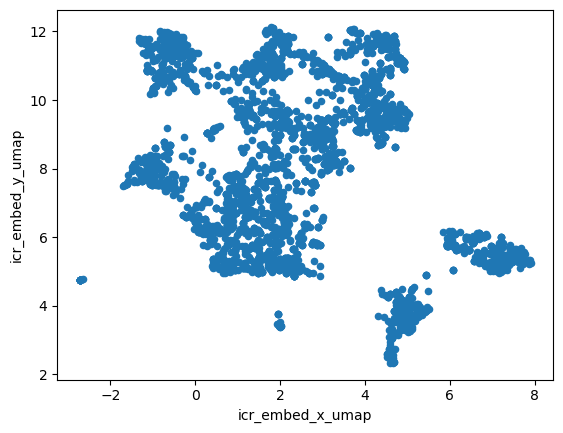

In [10]:
review_df.plot.scatter(x='icr_embed_x_umap', y='icr_embed_y_umap')
plt.show()

### Primary data complete, now extract the features we will work with

In [11]:
basic_features = [
     'id', 
     'regionname', 
     'project_name', 
     'pdo', 
     'boardapprovaldate', 
     'closingdate', 
     'closingyear', 
     'project_country', 
     'panel_country',
]

loan_features = [
    'financing_type',
    'financing_instr',
    'sector_percentage', # = percentage in primary sector
    'number_sectors',
    'practice_type_code',
    'n_practices',
    'gp_percentage',
    'hhi'
] 

sector_features = [
    'sector1', 'sector2', 'sector3', 'sector4', 'sector5', 'theme1', 'theme2'
]

cat_features = [
    'impagency',
    'cons_serv_reqd_ind',
    'supplementprojectflg',
    'prodlinetext',
    'parent_sector_name'
]

# embed_features = embed_cols
embed_features = [
    'pdo_embed_x_umap',
    'pdo_embed_y_umap',
    'dli_embed_x_umap',
    'dli_embed_y_umap'
]

review_embeds = [
    'icr_embed_x_umap',
    'icr_embed_y_umap'
]

In [12]:
common_features = basic_features + loan_features + sector_features + cat_features + embed_features
approv_features = [col for col in ipf_feature_cols if col not in common_features] + common_features
review_features = [col for col in during_project_features if col not in common_features] + review_embeds + common_features

In [13]:
approv_data = project_util.assemble_input_df(approv_df, approv_features, country_panel)

In [14]:
review_data = project_util.assemble_input_df(review_df, review_features, country_panel)

## Sector coding, running models @ project start


In [15]:
# remove these (if still present) as they have trivial importance and are expanding the feature space without gain
trivial_imp_features = [
    'cons_serv_reqd_ind', 
    'impagency',
    'prodlinetext',
    'supplementprojectflg'
]

### Approval data, default CLF + REG

In [16]:
approv_feature_cols = loan_features + cat_features + ['pdo_length'] + embed_features + ipf_feature_cols
approv_feature_cols = [col for col in approv_feature_cols if col not in trivial_imp_features]

approv_input_df, approv_health_results, approv_edu_results = project_util.construct_residual_df(
    data=approv_data,
    project_feature_cols=approv_feature_cols
)

Sector projects data:  1817  versus all projects:  10796
Clean observations:  944
Naive R squared of partialling out phase:  0.900083360307445  and f_p:  0.0
Clean within project characteristics:  2564
Projects with residual above mean:  1406
Projects with positive residual above threshold:  1236
Size of X train:  2307  and X test:  257  and width:  64


/home/luke/miniconda3/envs/causal/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


Size of X train:  2307  and X test:  257  and width:  64
Sector projects data:  1725  versus all projects:  10796
Clean observations:  753
Naive R squared of partialling out phase:  0.4644627519821902  and f_p:  1.1381902581644834e-96
Clean within project characteristics:  2211
Projects with residual above mean:  1208
Projects with positive residual above threshold:  1192
Size of X train:  1989  and X test:  222  and width:  62


/home/luke/miniconda3/envs/causal/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


Size of X train:  1989  and X test:  222  and width:  62


In [17]:
random_seed = 42
clf_default = RandomForestClassifier(min_samples_leaf=5)

# getting overfitting badly, so start pruning
cols_to_exclude = [
    "uppermiddle_income_appfy", # seems to not be adding much vs ln gdp per cap
    "focused_project", # shown above to not matter much
    "scattered_project", # as above,
    "gp", # has not entered significantly
    "pdo_length",
    "lngdp_ppp", # since already in controls
    "gp_percentage",
    "practice_type_code",
    "parent_sector_name" # worried this is leaking label
]

bin_scores, reg_scores, summed_imp, models = project_util.run_residual_reg(
    consolidated_df=approv_input_df,
    probe_feature_cols=approv_feature_cols,
    clf=clf_default, 
    columns_to_drop=cols_to_exclude
)

Size of X train:  4297  and X test:  478  and width:  43
Size of X train:  4297  and X test:  478  and width:  43


In [18]:
approv_input_df.residual_target_above_threshold.value_counts()

False    2428
True     2347
Name: residual_target_above_threshold, dtype: int64

ROC AUC:  0.9832939322301024
Reg train R2:  0.9651272902154074


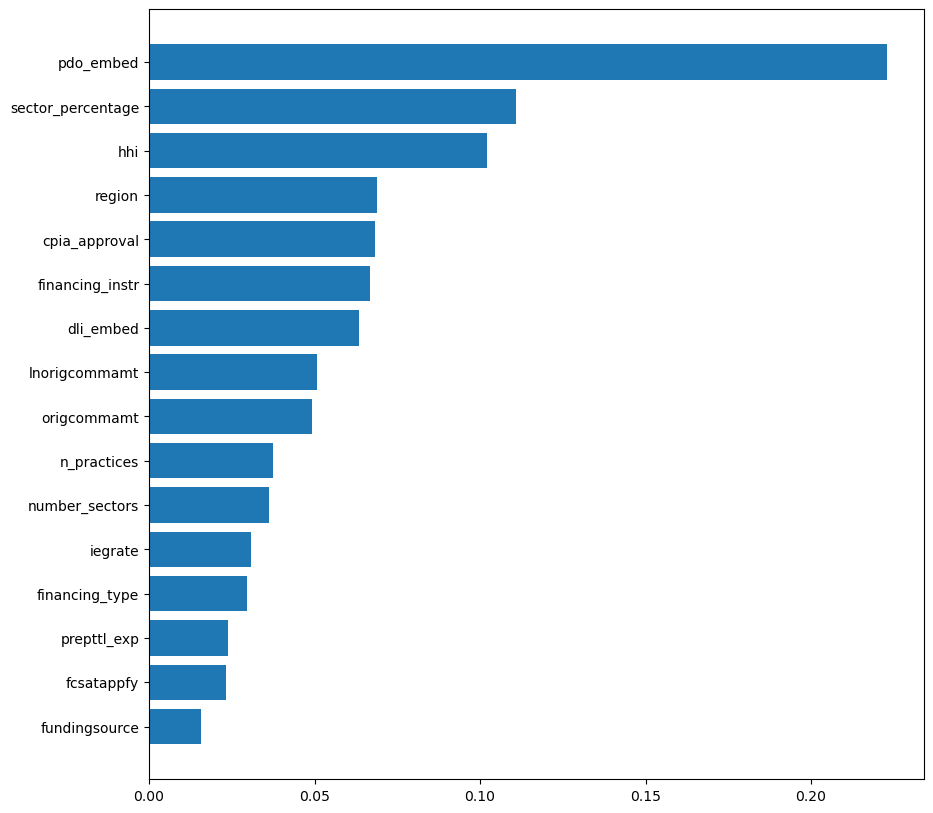

In [19]:
print("ROC AUC: ", bin_scores["roc_auc"])
print("Reg train R2: ", reg_scores["r2_train"])

plot_imp = { col: imp for col, imp in summed_imp.items() if imp > 0 }
plot_imp["pdo_embed"] = plot_imp.pop("pdo_embed_x_umap") + plot_imp.pop("pdo_embed_y_umap")
plot_imp["dli_embed"] = plot_imp.pop("dli_embed_x_umap") + plot_imp.pop("dli_embed_y_umap")
plot_imp = project_util.sort_imp(plot_imp)

plt.figure(figsize=(10, 10))
plt.barh(y=list(plot_imp.keys()), width=list(plot_imp.values()))
plt.show()

In [20]:
# take a look at the different financing instruments
approv_df.financing_instr.value_counts()

Investment Project Financing               20629
Specific Investment Loan                   12408
Development Policy Lending                  6400
Program-for-Results Financing               1649
Technical Assistance Loan                   1631
Financial Intermediary Loan                  910
Emergency Recovery Loan                      901
Adaptable Program Loan                       814
Structural Adjustment Loan                   752
Sector Adjustment Loan                       443
Learning and Innovation Loan                 313
Programmatic Structural Adjustment Loan       97
Poverty Reduction Support Credit              78
UNIDENTIFIED                                  52
Rehabilitation Loan                           43
Debt and Debt Service Reduction Loan          15
Special Structural Adjustment Loan             8
Name: financing_instr, dtype: int64

In [21]:
# slight violence to terminology here as we are doing 1-by-1 exclusion not cumulative
do_drop_one = False

if do_drop_one:
    cols_to_ablate = [col for col in approv_feature_cols if col not in cols_to_exclude and "embed" not in col]
    cols_to_ablate.append(["pdo_embed_x_umap", "pdo_embed_y_umap"])
    cols_to_ablate.append(["dli_embed_x_umap", "dli_embed_y_umap"])

    approv_drop_one = project_util.conduct_drop_one(
        clf=clf_default,
        data=approv_input_df,
        all_feature_cols=approv_feature_cols,
        cols_to_ablate=cols_to_ablate, 
        cols_to_exclude=cols_to_exclude,
        ref_bin_scores=bin_scores,
        ref_reg_scores=reg_scores,
        feature_imp=plot_imp,
        random_seed=random_seed
    )
    
    approv_drop_one.sort_values(by=['penalty_score'], ascending=False)

In [22]:
X = approv_input_df.drop(columns=["residual_target", f'residual_target_above_threshold'])
X = project_util.drop_agg_cols(X, cols_to_exclude)
reg_est = models[0]
bin_est = models[1]

In [23]:
reg_pred = reg_est.predict(X.drop(columns=['id']))
bin_est = reg_est.predict(X.drop(columns=['id']))

In [24]:
approv_input_df['reg_predict'] = reg_pred
approv_input_df['pos_proba'] = reg_pred

In [25]:
plot_df = approv_data.merge(approv_input_df[['id', 'reg_predict', 'pos_proba', 'residual_target']])

In [26]:
region_df = plot_df.groupby(['region']).agg(avg_residual_prediction=('reg_predict', 'mean'), avg_pos=('pos_proba', 'mean'))
region_df.sort_values(by=['avg_residual_prediction'], ascending=False)

,avg_residual_prediction,avg_pos
region,,
EAP,0.470124,0.470124
ECA,0.277980,0.277980
LCR,0.255486,0.255486
SAR,0.226205,0.226205
AFR,-0.078482,-0.078482
0,-0.192373,-0.192373
MNA,-0.523205,-0.523205


In [27]:
sector_df = plot_df.groupby(['parent_sector_name']).agg(
    count=('id', 'count'), avg_residual_prediction=('reg_predict', 'mean'), avg_pos=('pos_proba', 'mean'))
sector_df[sector_df['count'] > 1000].sort_values(by=['avg_residual_prediction'], ascending=False)

,count,avg_residual_prediction,avg_pos
parent_sector_name,,,
Health,2040,0.102922,0.102922
Public Admin,4117,0.051962,0.051962
Industry & Trade/Ser,1054,0.047826,0.047826
Education,4003,-0.068563,-0.068563
Social Protection,2313,-0.115226,-0.115226
Transportation,2059,-0.386089,-0.386089


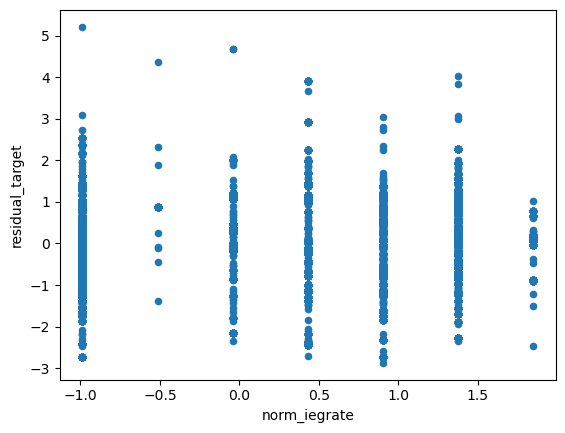

In [28]:
plot_df['norm_iegrate'] = (plot_df['iegrate'] - plot_df['iegrate'].mean()) / plot_df['iegrate'].std()

# show normalized ratings, just for sense of variance
plot_df.plot.scatter(x='norm_iegrate', y='residual_target')
plt.show()

### Now for at review time

In [29]:
review_feature_cols = loan_features + cat_features + ['pdo_length'] + review_embeds + during_project_features
review_feature_cols = [col for col in review_feature_cols if col not in trivial_imp_features]

review_input_df, review_health_results, review_edu_results = project_util.construct_residual_df(
    data=review_data,
    project_feature_cols=review_feature_cols
)

Sector projects data:  706  versus all projects:  3611
Clean observations:  343
Naive R squared of partialling out phase:  0.9151538190054039  and f_p:  7.452278871369624e-174
Clean within project characteristics:  1029
Projects with residual above mean:  615
Projects with positive residual above threshold:  585
Size of X train:  926  and X test:  103  and width:  47


/home/luke/miniconda3/envs/causal/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


Size of X train:  926  and X test:  103  and width:  47
Sector projects data:  601  versus all projects:  3611
Clean observations:  238
Naive R squared of partialling out phase:  0.44393903042968497  and f_p:  2.922044866168006e-26
Clean within project characteristics:  697
Projects with residual above mean:  412
Projects with positive residual above threshold:  368
Size of X train:  627  and X test:  70  and width:  46


/home/luke/miniconda3/envs/causal/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


Size of X train:  627  and X test:  70  and width:  46


In [30]:
review_bin_scores, review_reg_scores, review_summed_imp, review_models = project_util.run_residual_reg(
    consolidated_df=review_input_df,
    probe_feature_cols=review_feature_cols,
    clf=clf_default, 
    columns_to_drop=cols_to_exclude + ['gdpgrowthav']
)

Size of X train:  1553  and X test:  173  and width:  30
Size of X train:  1553  and X test:  173  and width:  30


In [31]:
review_bin_scores

{'default_score': 0.9132947976878613,
 'fscore_etc': (0.9078947368421053,
  0.8961038961038961,
  0.9019607843137255,
  None),
 'roc_auc': 0.9772050865800865,
 'roc_curve': (array([0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.01041667, 0.01041667, 0.02083333, 0.02083333, 0.02083333,
         0.03125   , 0.03125   , 0.05208333, 0.05208333, 0.07291667,
         0.07291667, 0.08333333, 0.08333333, 0.10416667, 0.10416667,
         0.13541667, 0.13541667, 0.15625   , 0.15625   , 0.16666667,
         0.16666667, 0.1875    , 0.20833333, 0.25      , 0.30208333,
         0.33333333, 0.34375   , 0.42708333, 0.46875   , 0.48958333,
         0.52083333, 0.60416667, 0.61458333, 0.63541667, 0.66666667,
         0.6875    , 0.71875   , 0.73958333, 0.76041667, 0.79166667,
         0.8125    , 0.82291667, 0.84375   , 0.89583333, 0.92708333,


In [32]:
review_summed_imp

{'icr_embed_x_umap': 0.10503834869295194,
 'icr_embed_y_umap': 0.1042849615592242,
 'hhi': 0.10220663030889691,
 'actprojlength': 0.090418731102025,
 'sector_percentage': 0.08287301674008124,
 'cpia_change': 0.07311350113030016,
 'financing_instr': 0.07215781899416104,
 'number_sectors': 0.07141408318440623,
 'oneh_ttl_turnover': 0.06726800282463251,
 'twoh_ttl_turnover': 0.049342430728153655,
 'n_practices': 0.04726862626278858,
 'iegrate': 0.04042846491987219,
 'iegsat': 0.03457912658228952,
 'changeprepttlisr12': 0.03211719672391214,
 'financing_type': 0.027489060246304625,
 'practice_type_code': 0,
 'gp_percentage': 0,
 'parent_sector_name': 0,
 'pdo_length': 0,
 'gdpgrowthav': 0}

Review ROC AUC:  0.9772050865800865
Review reg train R2:  0.9318417063237451


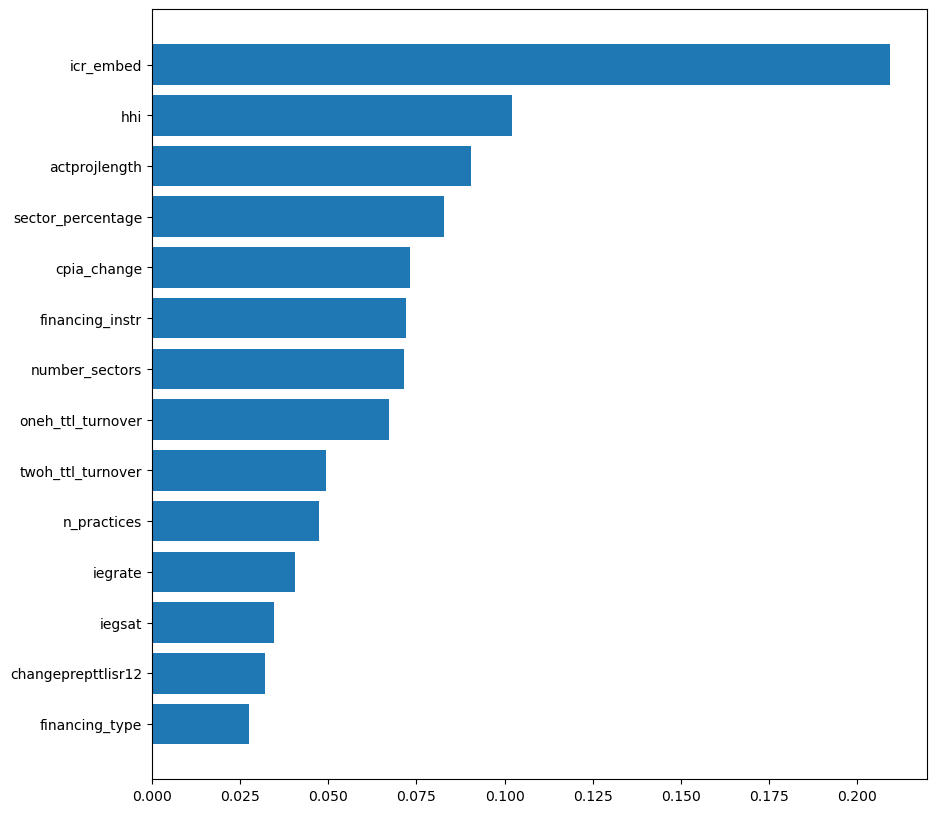

In [33]:
print("Review ROC AUC: ", review_bin_scores["roc_auc"])
print("Review reg train R2: ", review_reg_scores["r2_train"])

review_plot_imp = { col: imp for col, imp in review_summed_imp.items() if imp > 0 }
review_plot_imp["icr_embed"] = review_plot_imp.pop("icr_embed_x_umap") + review_plot_imp.pop("icr_embed_y_umap")
review_plot_imp = project_util.sort_imp(review_plot_imp)

plt.figure(figsize=(10, 10))
plt.barh(y=list(review_plot_imp.keys()), width=list(review_plot_imp.values()))
plt.show()

## Conduct cross-validation

In [34]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.linear_model import Lasso

In [35]:
binary_grid_search = {
    "logistic": dict(clf=Lasso(), params={}),
    "random_forest": dict(clf=RandomForestClassifier(random_state=42), params={
        "min_samples_leaf": [1, 5, 10],
        "max_depth": [10, None]
    }),
    "svc": dict(clf=SVC(probability=True), params={
        "C": [1, 10],
        "kernel": ["rbf", "sigmoid"]
    }),
    "xgb": dict(clf=XGBClassifier(), params={
        "learning_rate": [0.01, 0.1, 0.3],
        "min_child_weight": [1, 3, 6]
    })
}

In [36]:
X_cv = approv_input_df.drop(columns=['id', "residual_target", f'residual_target_above_threshold'])

y_reg = approv_input_df["residual_target"]
y_class = approv_input_df['residual_target_above_threshold']    

In [37]:
y_class.value_counts()

False    2428
True     2347
Name: residual_target_above_threshold, dtype: int64

In [38]:
approv_input_df.residual_target_above_threshold.value_counts()

False    2428
True     2347
Name: residual_target_above_threshold, dtype: int64

In [39]:
reload(project_util)

<module 'util.project' from '/home/luke/newproj/aid-outcomes-ml/notebooks/util/project.py'>

In [40]:
X_cv = project_util.drop_agg_cols(X_cv, cols_to_exclude)

In [41]:
X_cv.columns

Index(['sector_percentage', 'number_sectors', 'n_practices', 'hhi',
       'pdo_embed_x_umap', 'pdo_embed_y_umap', 'dli_embed_x_umap',
       'dli_embed_y_umap', 'origcommamt', 'lnorigcommamt', 'cpia_approval',
       'fcsatappfy', 'prepttl_exp', 'iegrate', 'financing_type_BLEND',
       'financing_type_IBRD', 'financing_type_IDA', 'financing_type_OTHER',
       'financing_type_UNKNOWN', 'financing_instr_0',
       'financing_instr_Adaptable Program Loan',
       'financing_instr_Development Policy Lending',
       'financing_instr_Emergency Recovery Loan',
       'financing_instr_Financial Intermediary Loan',
       'financing_instr_Investment Project Financing',
       'financing_instr_Learning and Innovation Loan',
       'financing_instr_Poverty Reduction Support Credit',
       'financing_instr_Programmatic Structural Adjustment Loan',
       'financing_instr_Sector Adjustment Loan',
       'financing_instr_Specific Investment Loan',
       'financing_instr_Structural Adjustment L

In [42]:
Xcv_train, Xcv_val, ycv_train, ycv_val = train_test_split(X_cv, y_class, test_size=0.2, stratify=y_class)
clf_tester = RandomForestClassifier(min_samples_leaf=5)
clf_tester.fit(Xcv_train, ycv_train)
print("Score: ", clf_tester.score(Xcv_val, ycv_val))

Score:  0.9738219895287958


In [43]:
gsearch_1 = GridSearchCV(
    estimator=RandomForestClassifier(), param_grid=[{"min_samples_leaf": [5]}], verbose=3.5, 
    cv=StratifiedKFold(shuffle=True)
)
gsearch_1.fit(X_cv, y_class)
#                          (min_samples_leaf=5)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 1/5] END ................min_samples_leaf=5;, score=0.966 total time=   0.5s
[CV 2/5] END ................min_samples_leaf=5;, score=0.962 total time=   0.3s
[CV 3/5] END ................min_samples_leaf=5;, score=0.974 total time=   0.3s
[CV 4/5] END ................min_samples_leaf=5;, score=0.975 total time=   0.4s
[CV 5/5] END ................min_samples_leaf=5;, score=0.980 total time=   0.3s


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=True),
             estimator=RandomForestClassifier(),
             param_grid=[{'min_samples_leaf': [5]}], verbose=3.5)

In [46]:
model_results = {}

for model_type in binary_grid_search:
    print("Running CV on: ", model_type)
    cv_clf = GridSearchCV(
        estimator=binary_grid_search[model_type]["clf"], 
        param_grid=binary_grid_search[model_type]["params"],
        return_train_score=True,
        verbose=1.5,
        cv=StratifiedKFold(shuffle=True)
    )
    cv_clf.fit(X_cv, y_class)
    print("Best score: ", cv_clf.best_score_)
    model_results[model_type] = cv_clf

Running CV on:  logistic
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
Best score:  -1.6451438003439733e-06
Running CV on:  random_forest
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV] END ...................max_depth=10, min_samples_leaf=1; total time=   0.3s
[CV] END ...................max_depth=10, min_samples_leaf=1; total time=   0.3s
[CV] END ...................max_depth=10, min_samples_leaf=1; total time=   0.4s
[CV] END ...................max_depth=10, min_samples_leaf=1; total time=   0.4s
[CV] END ...................max_depth=10, min_samples_leaf=1

/home/luke/miniconda3/envs/causal/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV] END .............learning_rate=0.01, min_child_weight=1; total time=   0.5s
[15:43:44] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/luke/miniconda3/envs/causal/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV] END .............learning_rate=0.01, min_child_weight=1; total time=   0.5s
[15:43:45] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/luke/miniconda3/envs/causal/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV] END .............learning_rate=0.01, min_child_weight=1; total time=   0.5s
[15:43:45] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/luke/miniconda3/envs/causal/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV] END .............learning_rate=0.01, min_child_weight=1; total time=   0.4s
[15:43:46] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/luke/miniconda3/envs/causal/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV] END .............learning_rate=0.01, min_child_weight=1; total time=   0.4s
[15:43:46] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/luke/miniconda3/envs/causal/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV] END .............learning_rate=0.01, min_child_weight=3; total time=   0.4s
[15:43:47] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/luke/miniconda3/envs/causal/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV] END .............learning_rate=0.01, min_child_weight=3; total time=   0.5s
[15:43:47] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/luke/miniconda3/envs/causal/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV] END .............learning_rate=0.01, min_child_weight=3; total time=   0.4s
[15:43:47] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/luke/miniconda3/envs/causal/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV] END .............learning_rate=0.01, min_child_weight=3; total time=   0.4s
[15:43:48] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/luke/miniconda3/envs/causal/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV] END .............learning_rate=0.01, min_child_weight=3; total time=   0.5s
[15:43:48] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/luke/miniconda3/envs/causal/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV] END .............learning_rate=0.01, min_child_weight=6; total time=   0.5s
[15:43:49] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/luke/miniconda3/envs/causal/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV] END .............learning_rate=0.01, min_child_weight=6; total time=   0.4s
[15:43:49] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/luke/miniconda3/envs/causal/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV] END .............learning_rate=0.01, min_child_weight=6; total time=   0.5s
[15:43:50] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/luke/miniconda3/envs/causal/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV] END .............learning_rate=0.01, min_child_weight=6; total time=   0.5s
[15:43:50] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/luke/miniconda3/envs/causal/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV] END .............learning_rate=0.01, min_child_weight=6; total time=   0.4s
[15:43:51] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/luke/miniconda3/envs/causal/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV] END ..............learning_rate=0.1, min_child_weight=1; total time=   0.5s
[15:43:51] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/luke/miniconda3/envs/causal/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV] END ..............learning_rate=0.1, min_child_weight=1; total time=   0.4s
[15:43:52] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/luke/miniconda3/envs/causal/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV] END ..............learning_rate=0.1, min_child_weight=1; total time=   0.5s
[15:43:52] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/luke/miniconda3/envs/causal/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV] END ..............learning_rate=0.1, min_child_weight=1; total time=   0.6s
[15:43:53] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/luke/miniconda3/envs/causal/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV] END ..............learning_rate=0.1, min_child_weight=1; total time=   0.6s
[15:43:53] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/luke/miniconda3/envs/causal/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV] END ..............learning_rate=0.1, min_child_weight=3; total time=   0.4s
[15:43:54] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/luke/miniconda3/envs/causal/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV] END ..............learning_rate=0.1, min_child_weight=3; total time=   1.0s
[15:43:55] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/luke/miniconda3/envs/causal/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV] END ..............learning_rate=0.1, min_child_weight=3; total time=   0.6s
[15:43:56] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/luke/miniconda3/envs/causal/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV] END ..............learning_rate=0.1, min_child_weight=3; total time=   0.5s
[15:43:56] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/luke/miniconda3/envs/causal/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV] END ..............learning_rate=0.1, min_child_weight=3; total time=   0.5s
[15:43:57] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/luke/miniconda3/envs/causal/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV] END ..............learning_rate=0.1, min_child_weight=6; total time=   0.4s
[15:43:57] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/luke/miniconda3/envs/causal/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV] END ..............learning_rate=0.1, min_child_weight=6; total time=   0.4s
[15:43:57] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/luke/miniconda3/envs/causal/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV] END ..............learning_rate=0.1, min_child_weight=6; total time=   0.5s
[15:43:58] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/luke/miniconda3/envs/causal/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV] END ..............learning_rate=0.1, min_child_weight=6; total time=   0.6s
[15:43:58] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/luke/miniconda3/envs/causal/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV] END ..............learning_rate=0.1, min_child_weight=6; total time=   0.6s
[15:43:59] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/luke/miniconda3/envs/causal/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV] END ..............learning_rate=0.3, min_child_weight=1; total time=   0.9s
[15:44:00] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/luke/miniconda3/envs/causal/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV] END ..............learning_rate=0.3, min_child_weight=1; total time=   0.5s
[15:44:00] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/luke/miniconda3/envs/causal/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV] END ..............learning_rate=0.3, min_child_weight=1; total time=   0.6s
[15:44:01] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/luke/miniconda3/envs/causal/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV] END ..............learning_rate=0.3, min_child_weight=1; total time=   0.5s
[15:44:02] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/luke/miniconda3/envs/causal/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV] END ..............learning_rate=0.3, min_child_weight=1; total time=   0.5s
[15:44:02] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/luke/miniconda3/envs/causal/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV] END ..............learning_rate=0.3, min_child_weight=3; total time=   0.5s
[15:44:03] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/luke/miniconda3/envs/causal/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV] END ..............learning_rate=0.3, min_child_weight=3; total time=   0.5s
[15:44:03] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/luke/miniconda3/envs/causal/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV] END ..............learning_rate=0.3, min_child_weight=3; total time=   0.4s
[15:44:04] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/luke/miniconda3/envs/causal/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV] END ..............learning_rate=0.3, min_child_weight=3; total time=   0.4s
[15:44:04] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/luke/miniconda3/envs/causal/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV] END ..............learning_rate=0.3, min_child_weight=3; total time=   0.4s
[15:44:04] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/luke/miniconda3/envs/causal/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV] END ..............learning_rate=0.3, min_child_weight=6; total time=   0.4s
[15:44:05] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/luke/miniconda3/envs/causal/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV] END ..............learning_rate=0.3, min_child_weight=6; total time=   0.4s
[15:44:05] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/luke/miniconda3/envs/causal/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV] END ..............learning_rate=0.3, min_child_weight=6; total time=   0.6s
[15:44:06] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/luke/miniconda3/envs/causal/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV] END ..............learning_rate=0.3, min_child_weight=6; total time=   1.6s
[15:44:07] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/luke/miniconda3/envs/causal/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV] END ..............learning_rate=0.3, min_child_weight=6; total time=   1.0s
[15:44:08] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/luke/miniconda3/envs/causal/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Best score:  0.971937172774869


In [47]:
best_scores = { model_type: model_results[model_type].best_score_ for model_type in binary_grid_search }

In [48]:
best_scores

{'logistic': -1.6451438003439733e-06,
 'random_forest': 0.9721465968586387,
 'svc': 0.9673298429319372,
 'xgb': 0.971937172774869}

In [49]:
model_results["random_forest"].best_params_

{'max_depth': 10, 'min_samples_leaf': 10}

In [50]:
X_cv_rev = review_input_df.drop(columns=['id', "residual_target", f'residual_target_above_threshold'])

y_reg_rev = review_input_df["residual_target"]
y_class_rev = review_input_df['residual_target_above_threshold']   

In [51]:
X_cv_rev = project_util.drop_agg_cols(X_cv_rev, cols_to_exclude)

In [52]:
review_model_results = {}

for model_type in binary_grid_search:
    print("Running CV on: ", model_type)
    rev_cv_clf = GridSearchCV(
        estimator=binary_grid_search[model_type]["clf"], 
        param_grid=binary_grid_search[model_type]["params"],
        return_train_score=True,
        verbose=1.5,
        cv=StratifiedKFold(shuffle=True)
    )
    rev_cv_clf.fit(X_cv_rev, y_class_rev)
    print("Best score: ", rev_cv_clf.best_score_)
    review_model_results[model_type] = rev_cv_clf

Running CV on:  logistic
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
Best score:  -1.0637901956744856e-05
Running CV on:  random_forest
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV] END ...................max_depth=10, min_samples_leaf=1; total time=   0.2s
[CV] END ...................max_depth=10, min_samples_leaf=1; total time=   0.2s
[CV] END ...................max_depth=10, min_samples_leaf=1; total time=   0.2s
[CV] END ...................max_depth=10, min_samples_leaf=1; total time=   0.3s
[CV] END ...................max_depth=10, min_samples_leaf=1

/home/luke/miniconda3/envs/causal/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/luke/miniconda3/envs/causal/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV] END .............learning_rate=0.01, min_child_weight=1; total time=   0.2s
[15:44:35] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END .............learning_rate=0.01, min_child_weight=1; total time=   0.2s


/home/luke/miniconda3/envs/causal/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/luke/miniconda3/envs/causal/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:44:35] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END .............learning_rate=0.01, min_child_weight=1; total time=   0.2s
[15:44:36] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/luke/miniconda3/envs/causal/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV] END .............learning_rate=0.01, min_child_weight=1; total time=   0.2s
[15:44:36] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/luke/miniconda3/envs/causal/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV] END .............learning_rate=0.01, min_child_weight=3; total time=   0.2s
[15:44:36] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/luke/miniconda3/envs/causal/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV] END .............learning_rate=0.01, min_child_weight=3; total time=   0.2s
[15:44:36] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END .............learning_rate=0.01, min_child_weight=3; total time=   0.2s


/home/luke/miniconda3/envs/causal/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/luke/miniconda3/envs/causal/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:44:36] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END .............learning_rate=0.01, min_child_weight=3; total time=   0.2s


/home/luke/miniconda3/envs/causal/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/luke/miniconda3/envs/causal/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:44:37] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END .............learning_rate=0.01, min_child_weight=3; total time=   0.2s
[15:44:37] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END .............learning_rate=0.01, min_child_weight=6; total time=   0.2s
[15:44:37] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END .............learning_rate=0.01, min_child_weight=6; total time=   0.2s
[

/home/luke/miniconda3/envs/causal/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/luke/miniconda3/envs/causal/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV] END .............learning_rate=0.01, min_child_weight=6; total time=   0.2s
[15:44:37] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/luke/miniconda3/envs/causal/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV] END .............learning_rate=0.01, min_child_weight=6; total time=   0.2s
[15:44:38] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END .............learning_rate=0.01, min_child_weight=6; total time=   0.2s
[15:44:38] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/luke/miniconda3/envs/causal/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/luke/miniconda3/envs/causal/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV] END ..............learning_rate=0.1, min_child_weight=1; total time=   0.2s
[15:44:38] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END ..............learning_rate=0.1, min_child_weight=1; total time=   0.2s
[15:44:38] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/luke/miniconda3/envs/causal/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/luke/miniconda3/envs/causal/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV] END ..............learning_rate=0.1, min_child_weight=1; total time=   0.2s
[15:44:38] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/luke/miniconda3/envs/causal/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV] END ..............learning_rate=0.1, min_child_weight=1; total time=   0.5s
[15:44:39] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END ..............learning_rate=0.1, min_child_weight=1; total time=   0.2s
[15:44:39] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/luke/miniconda3/envs/causal/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/luke/miniconda3/envs/causal/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV] END ..............learning_rate=0.1, min_child_weight=3; total time=   0.2s
[15:44:39] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END ..............learning_rate=0.1, min_child_weight=3; total time=   0.2s
[15:44:39] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/luke/miniconda3/envs/causal/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/luke/miniconda3/envs/causal/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV] END ..............learning_rate=0.1, min_child_weight=3; total time=   0.2s
[15:44:40] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END ..............learning_rate=0.1, min_child_weight=3; total time=   0.2s
[15:44:40] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/luke/miniconda3/envs/causal/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/luke/miniconda3/envs/causal/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV] END ..............learning_rate=0.1, min_child_weight=3; total time=   0.3s
[15:44:40] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END ..............learning_rate=0.1, min_child_weight=6; total time=   0.1s
[15:44:40] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/luke/miniconda3/envs/causal/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/luke/miniconda3/envs/causal/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV] END ..............learning_rate=0.1, min_child_weight=6; total time=   0.2s
[15:44:40] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END ..............learning_rate=0.1, min_child_weight=6; total time=   0.2s
[15:44:41] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/luke/miniconda3/envs/causal/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/luke/miniconda3/envs/causal/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV] END ..............learning_rate=0.1, min_child_weight=6; total time=   0.2s
[15:44:41] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END ..............learning_rate=0.1, min_child_weight=6; total time=   0.2s
[15:44:41] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/luke/miniconda3/envs/causal/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/luke/miniconda3/envs/causal/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV] END ..............learning_rate=0.3, min_child_weight=1; total time=   0.2s
[15:44:41] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END ..............learning_rate=0.3, min_child_weight=1; total time=   0.2s
[15:44:41] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/luke/miniconda3/envs/causal/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/luke/miniconda3/envs/causal/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV] END ..............learning_rate=0.3, min_child_weight=1; total time=   0.2s
[15:44:42] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END ..............learning_rate=0.3, min_child_weight=1; total time=   0.2s
[15:44:42] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/luke/miniconda3/envs/causal/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/luke/miniconda3/envs/causal/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV] END ..............learning_rate=0.3, min_child_weight=1; total time=   0.2s
[15:44:42] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END ..............learning_rate=0.3, min_child_weight=3; total time=   0.1s
[15:44:42] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/luke/miniconda3/envs/causal/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/luke/miniconda3/envs/causal/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV] END ..............learning_rate=0.3, min_child_weight=3; total time=   0.2s
[15:44:42] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END ..............learning_rate=0.3, min_child_weight=3; total time=   0.2s
[15:44:42] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/luke/miniconda3/envs/causal/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/luke/miniconda3/envs/causal/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV] END ..............learning_rate=0.3, min_child_weight=3; total time=   0.2s
[15:44:43] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END ..............learning_rate=0.3, min_child_weight=3; total time=   0.1s
[15:44:43] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/luke/miniconda3/envs/causal/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/luke/miniconda3/envs/causal/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV] END ..............learning_rate=0.3, min_child_weight=6; total time=   0.2s
[15:44:43] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END ..............learning_rate=0.3, min_child_weight=6; total time=   0.1s
[15:44:43] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/luke/miniconda3/envs/causal/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/luke/miniconda3/envs/causal/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV] END ..............learning_rate=0.3, min_child_weight=6; total time=   0.2s
[15:44:43] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END ..............learning_rate=0.3, min_child_weight=6; total time=   0.2s
[15:44:43] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/luke/miniconda3/envs/causal/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/luke/miniconda3/envs/causal/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV] END ..............learning_rate=0.3, min_child_weight=6; total time=   0.2s
[15:44:44] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Best score:  0.8997587333500879


/home/luke/miniconda3/envs/causal/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


In [53]:
best_scores_rev = { model_type: review_model_results[model_type].best_score_ for model_type in binary_grid_search }

In [54]:
best_scores_rev

{'logistic': -1.0637901956744856e-05,
 'random_forest': 0.8916679232638016,
 'svc': 0.8858523917232135,
 'xgb': 0.8997587333500879}